In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Mixture Models

## (1-dim) Gaussian distribution

In [2]:
# draw points from two normal distributions
values1 = np.random.normal(loc=-10, scale=10, size=10000)
values2 = np.random.normal(loc=2, scale=1, size=10000)

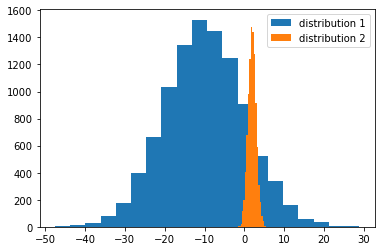

In [3]:
# plot histograms
plt.hist(values1,bins=20,label='distribution 1')
plt.hist(values2,bins=20,label='distribution 2')
plt.legend()
plt.show()

## Multivariate (2-dim) Gaussian distribution

In [4]:
def covariance_matrix(direction,evalues):
    'builds a 2x2 covariance matrix'
    
    # first vector
    q1 = np.array(direction)
    q1 = q1/np.linalg.norm(q1) # normalize
    
    # second vector (perpendicular to q1)
    q2 = np.array([-q1[1],q1[0]])
    q2 = q2/np.linalg.norm(q2) # normalize
    
    # orthogonal matrix Q
    Q = np.zeros((2,2))
    Q[:,0] = q1
    Q[:,1] = q2
    
    # diagonal matrix
    D = np.diag(evalues)
    
    return Q.dot(D.dot(Q.T))

In [5]:
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov1

array([[8.2, 3.6],
       [3.6, 2.8]])

In [6]:
cov2 = covariance_matrix(direction=[1,0],evalues=[1,1])
cov2

array([[1., 0.],
       [0., 1.]])

In [7]:
mean1 = np.array([5,5])
mean2 = np.array([0,0])

In [8]:
X1 = np.random.multivariate_normal(mean = mean1, cov = cov1, size = 1000)
X2 = np.random.multivariate_normal(mean = mean2, cov = cov2, size = 1000)

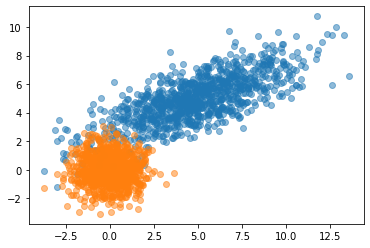

In [9]:
plt.scatter(X1[:,0],X1[:,1],label='distribution 1',alpha=0.5)
plt.scatter(X2[:,0],X2[:,1],label='distribution 2',alpha=0.5)

In [10]:
mean1,mean2

(array([5, 5]), array([0, 0]))

In [11]:
# maximum likelihood estimation
np.mean(X1,axis=0), np.mean(X2,axis=0)

(array([4.81846017, 4.93238988]), array([-0.02338236, -0.01743454]))

In [12]:
cov1, cov2

(array([[8.2, 3.6],
        [3.6, 2.8]]),
 array([[1., 0.],
        [0., 1.]]))

In [13]:
# maximum likelihood estimation (rowvar=False : each row of X is a datapoint)
np.cov(X1,rowvar=False), np.cov(X2,rowvar=False)

(array([[8.21351423, 3.45906609],
        [3.45906609, 2.74447275]]),
 array([[ 1.01126889, -0.00327379],
        [-0.00327379,  1.00063768]]))

## Gaussian mixtures

In [14]:
# Gaussian dist. probabilities
pi = [0.05,0.25,0.7]
# means
mean = [[10,5],[0,0],[-10,-10]]
#  covariance matrices
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov2 = covariance_matrix(direction=[0,1],evalues=[2,2])
cov3 = covariance_matrix(direction=[1,1],evalues=[2,20])
cov = [cov1, cov2, cov3]

In [15]:
# sample m points from the Gaussian mixture (k=3)
m = 100
k = 3 
dist = np.random.choice(k,m,p=pi)
X = np.zeros((m,2))
for i in range(k):
    # number of points from dist. i
    ni = np.sum(dist==i)
    X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)

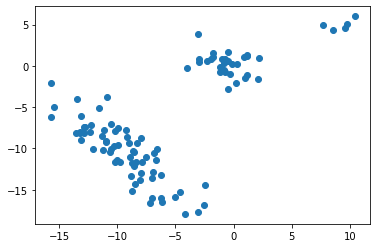

In [16]:
plt.scatter(X[:,0],X[:,1])

## Expectation-Maximization (EM) algorithm

In [17]:
def evaluate_multivariate_normal(X,mean,cov):
    m,n = X.shape
    return np.exp(-0.5*np.array([(X[i]-mean).dot((np.linalg.inv(cov)).dot(X[i]-mean))
                        for i in range(m)])) /  np.sqrt(np.linalg.det(cov)*(2*np.pi)**n)

In [18]:
def sample_gaussian_mixture(m,cov,mean,pi):
    k = len(mean) # number of gaussian distributions
    dist = np.random.choice(k,m,p=pi) # distributions
    X = np.zeros((m,2))
    for i in range(k):
        ni = np.sum(dist==i) # number of points from dist. i
        X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)
    return X

## Step by step example

In [19]:
# toy example:

#  dist. probabilities
pi = [0.8,0.1,0.1]
# means
mean1 = np.array([2,2])
mean2 = np.array([-2,-2])
mean3 = np.array([2,-2])
mean = [mean1,mean2,mean3]
# covariance matrices
cov1 = covariance_matrix(direction=[2,1],evalues=[1,.2])
cov2 = covariance_matrix(direction=[0,1],evalues=[0.1,0.1])
cov3 = covariance_matrix(direction=[1,0],evalues=[2,0.2])
cov = [cov1,cov2,cov3]

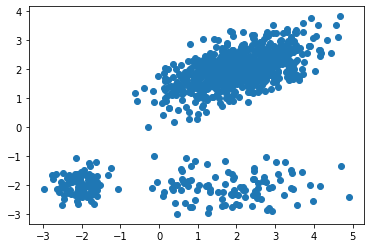

In [20]:
# sample m points from the Gaussian mixture
m = 1000
X = sample_gaussian_mixture(m,cov,mean,pi)
plt.scatter(X[:,0],X[:,1])

In [21]:
def plot_log_probability_distribution(X,cov,mean,pi):
    """
    this function plots:
        - level curves of the proba. distribution (negative logarithm)
        - cluster means
        - cluster boundaries
    
    """
    from matplotlib.colors import LogNorm  
    resolution = 500
    
    # number of clusters
    k = len(pi)
    
    # create a mesh grid
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    points = np.c_[xx.ravel(), yy.ravel()]
    Rpoints = np.zeros((resolution**2,k))
    for i in range(k):
        Rpoints[:,i] = evaluate_multivariate_normal(points,mean[i],cov[i])
    # multiply by cluster probabilities pi
    Rpoints = Rpoints*pi
    # sum along columns
    prob = -np.log(np.sum(Rpoints,axis=1).reshape(xx.shape))
    # cluster prediction
    pred = np.argmax(Rpoints,axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, prob,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))

    plt.contour(xx, yy, prob,linewidths=1,colors='black',
               norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, pred,
                    linewidths=2, colors='r', linestyles='dashed')
    # plot means
    for i in range(k):
        plt.scatter(mean[i][0],mean[i][1],
                    marker='o', s=20, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(mean[i][0],mean[i][1],
                    marker='x', s=50, linewidths=2,
                    color='r', zorder=11, alpha=1)

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plt.colorbar()
    plt.title('log probability distribution')

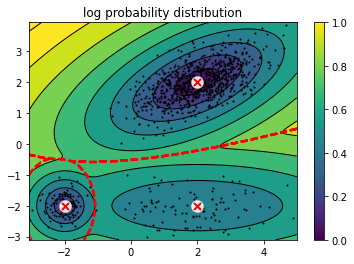

In [22]:
# plot the log-probability distribution (negative logarithm of the probability distribution)
plot_log_probability_distribution(X,cov,mean,pi)

In [23]:
# size of X
m,n = X.shape

In [24]:
# number of clusters
k = 3

In [25]:
# cluster probabilities initialization
pi = [1/k for i in range(k)]
pi

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

In [26]:
# covariance matrices initialization
cov = [np.eye(n) for i in range(k)] # identity matrices
cov

[array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]])]

In [27]:
# means initialization 1: choose k datapoints at random
mean = X[np.random.choice(m,k,replace=False)]
mean

array([[1.7420158 , 1.78783199],
       [2.73640529, 1.24150572],
       [2.26407648, 2.08576367]])

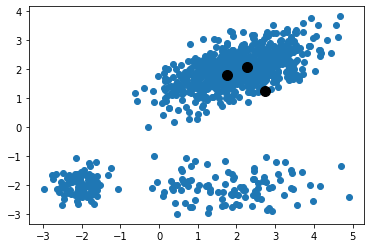

In [28]:
plt.scatter(X[:,0],X[:,1])
plt.scatter(mean[0,0],mean[0,1], s=100,color='black')
plt.scatter(mean[1,0],mean[1,1], s=100,color='black')
plt.scatter(mean[2,0],mean[2,1], s=100,color='black')

In [29]:
from sklearn.metrics import pairwise_distances

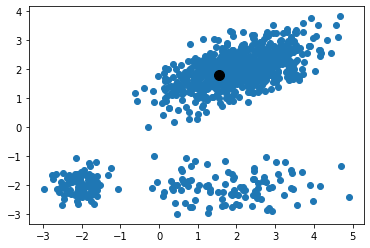

In [30]:
# means initialization 2: greedy initialization
mean = np.zeros((k,2))
# first mean:  selects the first mean randomly from the data points
mean[0] = X[np.random.choice(m,1)]
plt.scatter(X[:,0],X[:,1])
plt.scatter(mean[0,0],mean[0,1], s=100,color='black')

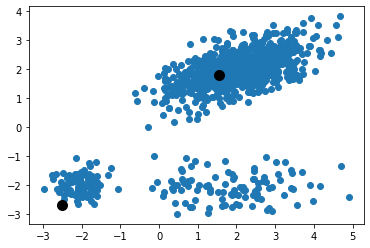

In [31]:
# second mean: selects the  point that is farthest from the first mean
mean[1] = X[np.argmax(pairwise_distances(X,mean[[0]]))]

plt.scatter(X[:,0],X[:,1])
plt.scatter(mean[0,0],mean[0,1], s=100,color='black')
plt.scatter(mean[1,0],mean[1,1], s=100,color='black')

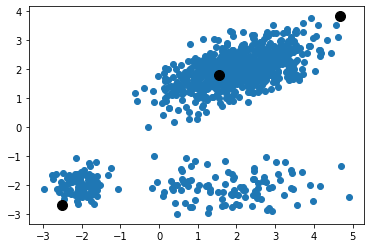

In [32]:
#  third mean: selects the  point that is farthest from the first and second means
mean[2]=X[np.argmax(np.sum(pairwise_distances(X,mean[[0,1]]),axis=1))]

plt.scatter(X[:,0],X[:,1])
plt.scatter(mean[0,0],mean[0,1], s=100,color='black')
plt.scatter(mean[1,0],mean[1,1], s=100,color='black')
plt.scatter(mean[2,0],mean[2,1], s=100,color='black')

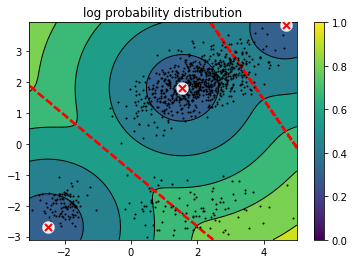

In [33]:
# initial log-probability distribution
plot_log_probability_distribution(X,cov,mean,pi)

In [34]:
# E-step

# initialize responsibility matrix
R = np.zeros((m,k))
# for each cluster, compute responsibilities
for c in range(k):
    R[:,c] = evaluate_multivariate_normal(X,mean[c],cov[c])
# multiply each column by its cluster probability pi_c
R = R*pi
# normalize rows
R = R/np.sum(R,axis=1,keepdims=True)

In [35]:
# M-step
mc = np.sum(R,axis=0)
# update cluster probabilities
pi = mc/m
pi

array([0.77854848, 0.13823453, 0.083217  ])

In [36]:
# update means and covariance matrices
for c in range(k):
    mean[c] = np.average(X,axis=0,weights=R[:,c])
    cov[c] = np.cov(X,rowvar=False, aweights=R[:,c])

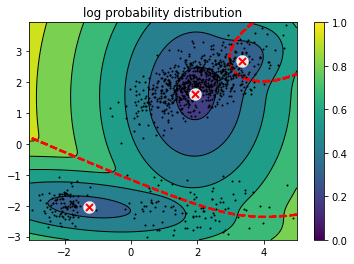

In [37]:
plot_log_probability_distribution(X,cov,mean,pi)

In [38]:
# repeat E and M steps

# for each cluster, compute responsibilities
for c in range(k):
    R[:,c] = evaluate_multivariate_normal(X,mean[c],cov[c])
# multiply each column by its cluster probability pi_c
R = R*pi
# normalize rows
R = R/np.sum(R,axis=1,keepdims=True)

# M-step
mc = np.sum(R,axis=0)
# update cluster probabilities
pi = mc/m
# update means and covariance matrices
for c in range(k):
    mean[c] = np.average(X,axis=0,weights=R[:,c])
    cov[c] = np.cov(X,rowvar=False, aweights=R[:,c])

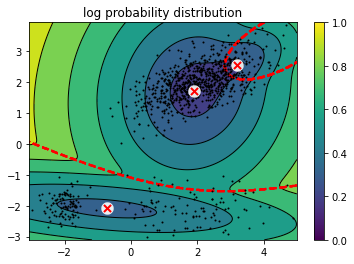

In [39]:
plot_log_probability_distribution(X,cov,mean,pi)

In [40]:
def em(X,k,max_iter=100):
    'expectation-maximization algorithm'
    
    # size of X
    m,n = X.shape
    
    # initializations
    cov = [np.eye(n) for i in range(k)] # identity matrices
    pi = [1/k for i in range(k)]
    # greedy initialization
    from sklearn.metrics import pairwise_distances
    mean = np.zeros((k,n))
    mean[0] = X[np.random.choice(m,1)]
    for i in range(1,k):
        dist = np.sum(pairwise_distances(X,mean[0:i]),axis=1)
        mean[i] = X[np.argmax(dist)]
    
    
    # initialize responsibility matrix
    R = np.zeros((m,k))
    
    # EM iterations
    for i in range(max_iter):
        # EXPECTATION STEP
        for i in range(k):
            R[:,i] = evaluate_multivariate_normal(X,mean[i],cov[i])
        # multiply by cluster probabilities pi
        R = R*pi
        # normalize rows
        R = R/np.sum(R,axis=1,keepdims=True)
        
        # MAXIMIZATION STEP
        mc = np.sum(R,axis=0)
        pi = mc/m
        for i in range(k):
            # weighted mean
            mean[i] = np.average(X,axis=0,weights=R[:,i])
            # weighted covariance matrix
            cov[i] = np.cov(X,rowvar=False,aweights=R[:,i])
    return cov,mean,pi

In [41]:
k = 3
max_iter = 200
cov,mean,pi=em(X,k,max_iter)

In [42]:
mean

array([[ 1.70197715,  1.92940391],
       [-0.09944904, -2.01937632],
       [ 2.70437743,  2.13851254]])

In [43]:
cov

[array([[0.63550759, 0.25675147],
        [0.25675147, 0.3189603 ]]),
 array([[ 4.48833823, -0.09111861],
        [-0.09111861,  0.1689686 ]]),
 array([[0.48315596, 0.22691609],
        [0.22691609, 0.29498406]])]

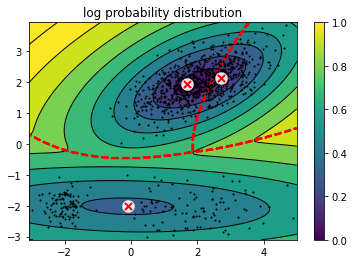

In [44]:
plot_log_probability_distribution(X,cov,mean,pi)

In [45]:
def cluster_probabilities(X,cov,mean,pi):
    m,n = X.shape
    k = len(pi)
    
    # responsibility matrix
    R = np.zeros((m,k))
    for i in range(k):
        R[:,i] = evaluate_multivariate_normal(X,mean[i],cov[i])
    # multiply by cluster probabilities pi
    R = R*pi
    # normalize rows
    R = R/np.sum(R,axis=1,keepdims=True)
    return R

In [46]:
newX = np.array([[1,-2],[2,0],[-2,-3]])
newX

array([[ 1, -2],
       [ 2,  0],
       [-2, -3]])

In [47]:
cluster_probabilities(newX,cov,mean,pi).round(2)

array([[0.  , 1.  , 0.  ],
       [0.45, 0.  , 0.54],
       [0.  , 1.  , 0.  ]])

In [48]:
def cluster_prediction(X,cov,mean,pi):
    R = cluster_probabilities(X,cov,mean,pi)
    return np.argmax(R,axis=1)

In [49]:
cluster_prediction(newX,cov,mean,pi)

array([1, 2, 1], dtype=int64)

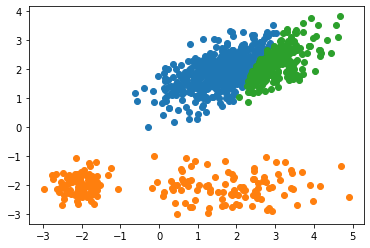

In [50]:
clusters = cluster_prediction(X,cov,mean,pi)
for i in range(k):
    plt.scatter(X[clusters==i,0],X[clusters==i,1])

## Irises and penguins revisited

In [51]:
import pandas as pd

In [52]:
# load the iris dataset
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Practice-bis/master/Data/iris.csv'
data = pd.read_csv(url)
data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [53]:
X = data[['sepal_length','sepal_width','petal_length','petal_width']].to_numpy()

In [54]:
k = 3
cov,mean,pi=em(X,k)

In [55]:
clusters = cluster_prediction(X,cov,mean,pi)

In [56]:
data[clusters==0].species.value_counts()

Iris-versicolor    13
Iris-virginica      4
Name: species, dtype: int64

In [57]:
data[clusters==1].species.value_counts()

Iris-virginica     46
Iris-versicolor    37
Name: species, dtype: int64

In [58]:
data[clusters==2].species.value_counts()

Iris-setosa    50
Name: species, dtype: int64

In [59]:
# load the data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/penguins_size.csv'
data = pd.read_csv(url)
data

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [60]:
data.dropna(axis=0,inplace=True)

In [61]:
X = data[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].to_numpy()
X = X/np.max(X,axis=0)

In [62]:
k = 3
cov,mean,pi=em(X,k,max_iter=1000)

In [63]:
clusters = cluster_prediction(X,cov,mean,pi)

In [64]:
data[clusters==0].species.value_counts()

Chinstrap    65
Adelie        2
Name: species, dtype: int64

In [65]:
data[clusters==1].species.value_counts()

Gentoo    120
Name: species, dtype: int64

In [66]:
data[clusters==2].species.value_counts()

Adelie       144
Chinstrap      3
Name: species, dtype: int64

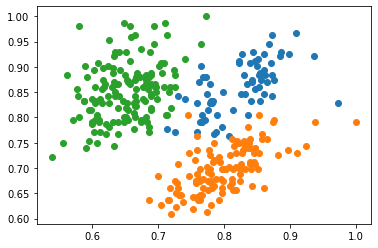

In [67]:
for i in range(k):
    plt.scatter(X[clusters==i,0],X[clusters==i,1])